# Homework 01: due 2025/03/20 12:20 p.m
## Resources
### - Tutorial: https://www.kaggle.com/prashant111/svm-classifier-tutorial
### - Kaggle: https://www.kaggle.com/t/522a2741502e409a965caa62b72b1dfc
## Instructions
### - Please answer the following questions and work directly on this Jupyter notebook.

### - Make sure the code can be run and show the results and figures properly. Do not clear the output of any cell.

### - Please write down your observations using markdown cells for your code briefly.

#### Note that it's fine if you don't follow the hint, there is also no restriction for same figure setting as the provided example

# SVM
- classification and regression outlier detection purposes
-



In [3]:
# Import necessary modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns # for statistical data visualization
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42) # DO NOT MODIFY THIS LINE

In [1]:
# Creating datasets (DO NOT MODIFY THIS PART)
def modified_make_moons(n_samples=1000, noise=0.15):

    # Basic moons dataset with noise
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)
    
    # Add rotation
    angle = np.pi / 4  # 45 degrees
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    X = np.dot(X, rotation_matrix)
    
    # Add a third feature (related to the boundary) with noise
    third_feature = 0.5 * X[:, 0] * X[:, 1] + 0.1 * np.random.randn(n_samples)
    X = np.column_stack((X, third_feature))
    
    # Uneven class distribution (70/30 split)
    class0_indices = np.where(y == 0)[0]
    remove_indices = class0_indices[:int(0.4 * len(class0_indices))]
    X = np.delete(X, remove_indices, axis=0)
    y = np.delete(y, remove_indices)
    
    return X, y

def modified_make_checkerboard(n_samples=1000, noise=0.08, size=4):

    x = np.random.uniform(0, size, n_samples)
    y = np.random.uniform(0, size, n_samples)
    
    # Checkerboard pattern
    labels = np.ones(n_samples)
    labels[(x.astype(int) % 2 == y.astype(int) % 2)] = 0
    
    # Apply nonlinear transformation to distort the grid
    x_transformed = x + 0.15 * np.sin(y * np.pi)
    y_transformed = y + 0.15 * np.sin(x * np.pi)
    
    # Add higher density in certain regions
    extra_samples = int(n_samples * 0.3)
    x_extra = np.random.uniform(1.0, 2.0, extra_samples)
    y_extra = np.random.uniform(1.0, 2.0, extra_samples)
    labels_extra = np.ones(extra_samples)
    labels_extra[(x_extra.astype(int) % 2 == y_extra.astype(int) % 2)] = 0
    
    # Add transformation
    x_extra_transformed = x_extra + 0.15 * np.sin(y_extra * np.pi)
    y_extra_transformed = y_extra + 0.15 * np.sin(x_extra * np.pi)
    
    x_final = np.concatenate([x_transformed, x_extra_transformed])
    y_final = np.concatenate([y_transformed, y_extra_transformed])
    labels_final = np.concatenate([labels, labels_extra])
    
    # Add noise (flipping some labels)
    if noise > 0:
        flip_indices = np.random.choice(len(labels_final), int(noise * len(labels_final)), replace=False)
        labels_final[flip_indices] = 1 - labels_final[flip_indices]
    
    # Add a third feature
    z = 0.2 * np.sin(x_final * y_final * np.pi) + 0.05 * np.random.randn(len(x_final))
    features = np.vstack([x_final, y_final, z]).T
    
    return features, labels_final

## 1. Kernel function and hyper paramters of support vector machine.
### Visualization Requirements
#### Please make the scatter plots with data for __*every sub-question*__.
#### The plotted figure should contain three parts:
1. Normal scatter plot
2. Scatter plot with decision boundary
3. Scatter plot with probability surface

##### Here is the figure example:
![alternatvie text](https://lh3.googleusercontent.com/d/1gAZmZ8xIr66eqNmi6RyqJroTVVHaaK_j)



### 1-1. Kernel Function Comparison (5%)
#### Please use the __**svc**__ function in scikit-learn module to load and compare the impact of different kernel functions on the given data. Try at least ***linear, poly & rbf*** kernel functions and set hyper parameters ***C, degree*** and ***gamma*** as default. Write down your observation. (5%)
##### #One plotted figure for each kernel you tried

In [4]:
# Load the data (Do not change this line)
X, y = modified_make_moons()
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Notes for SVM
- default kernel parameter : rbf (we can pass values like poly, linear, sigmoid or callable function.)
- linear kernel : K(xi , xj ) = xiT xj --
    - mostly used when there are large number of features in a dataset. ex: text classification purposes
    - Training with a linear kernel is usually faster (only need to optimize the C regularization parameter)
- Polynomial Kernel : K(xi , xj ) = (γxiT xj + r)d , γ > 0
    - popular in Natural Language Processing
    - common degree is d = 2 (quadratic) (larger degrees tend to overfit on NLP problems)
- Radial Basis Function Kernel : 
    - a general purpose kernel
    - used when we have no prior knowledge about the data
    


In [6]:
# --- Your svc models ---
# Do not modify the variable of "random_state"

# Define different kernels
model_linear = SVC(kernel='linear', probability=True, random_state=42)
model_poly = SVC(kernel='poly', probability=True, random_state=42)
model_rbf = SVC(kernel='rbf', probability=True, random_state=42)
models = [model_linear, model_poly, model_rbf]
kernels = ['linear', 'poly', 'rbf']
# Train models
for model in models:
    model.fit(X, y)



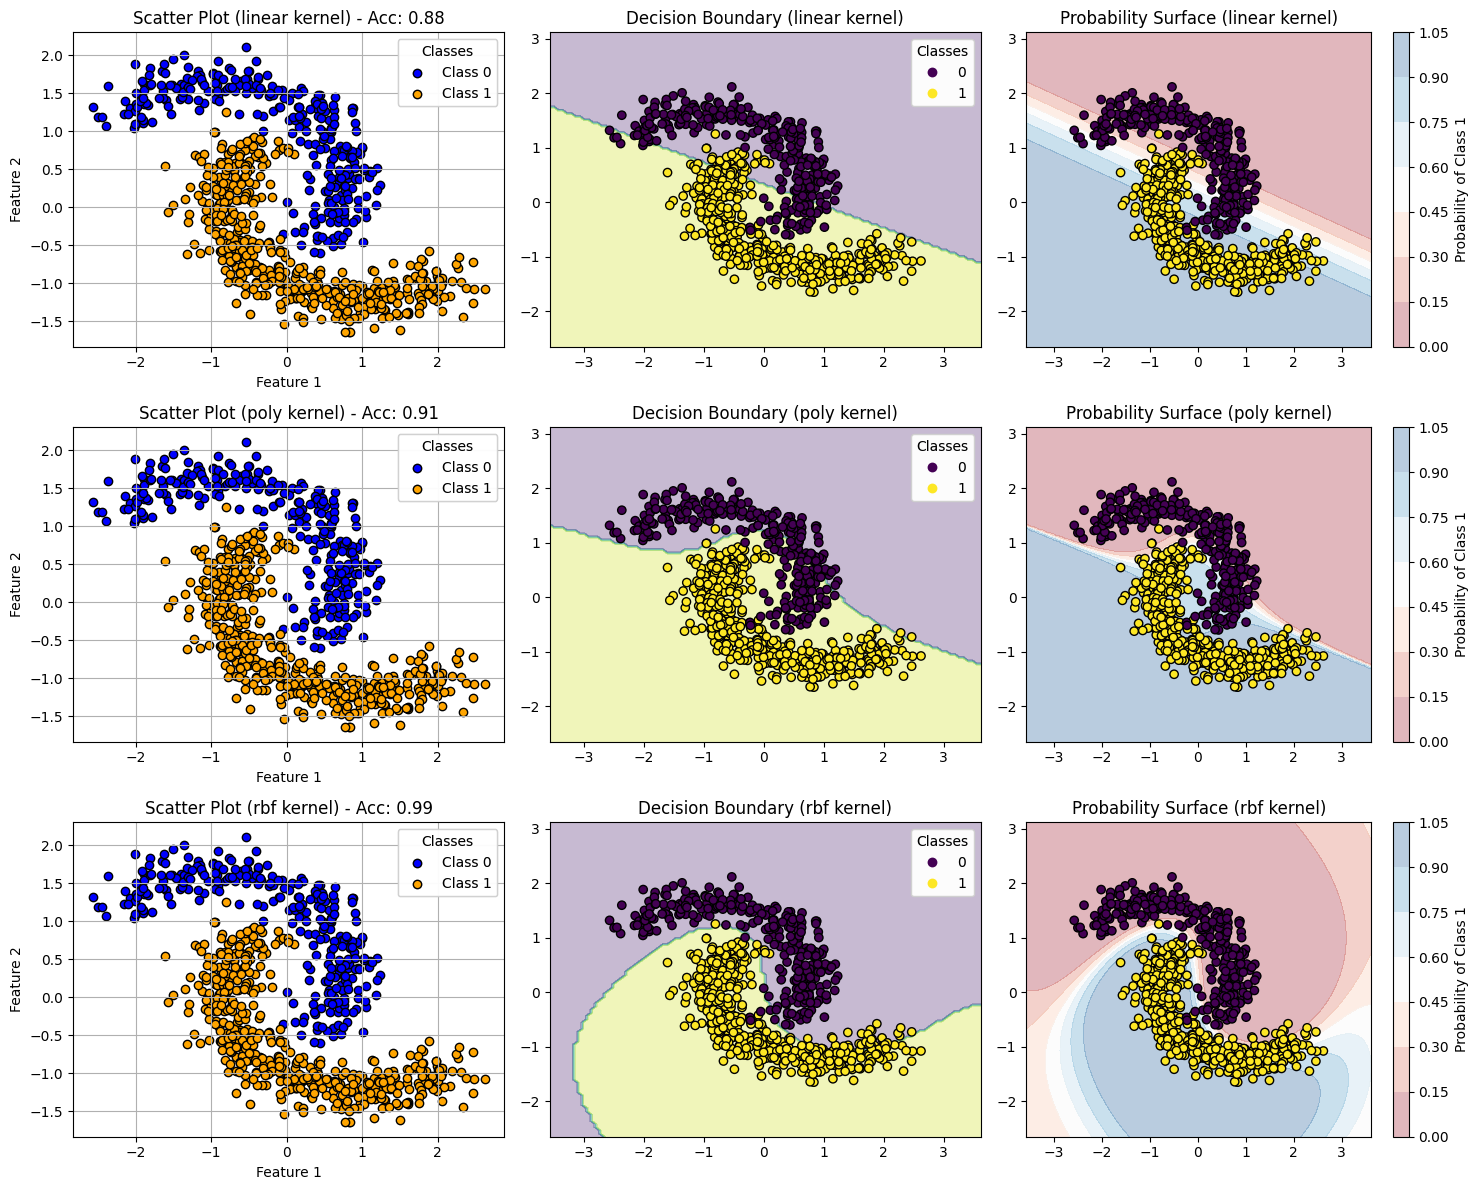

In [7]:
# --- Plot function ---
# some general plt settings 
fig, axes = plt.subplots(len(models), 3, figsize=(15, 12))

for i, model in enumerate(models):
    # Compute accuracy
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    
    # 1 Normal scatter
    """
    Parameters:
    -----------
    X : array-like
        Feature data
    y : array-like
        Labels
    title : str
        Plot title
    ax : matplotlib.axes, default=None
        Axes to plot on
    """
    ax = axes[i, 0]
    #scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
    #legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    # 類別 0
    ax.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", edgecolors='k', label="Class 0")
    # 類別 1
    ax.scatter(X[y == 1, 0], X[y == 1, 1], color="orange", edgecolors='k', label="Class 1")
    legend1 = ax.legend(title="Classes")
    ax.add_artist(legend1)
    ax.set_title(f"Scatter Plot ({model.kernel} kernel) - Acc: {accuracy:.2f}")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.grid(True)

    # 2 Decision boundary
    """
    Parameters:
    -----------
    model : SVC
        Trained SVM model
    X : array-like
        Feature data
    y : array-like
        Labels
    title : str
        Plot title
    ax : matplotlib.axes, default=None
        Axes to plot on
    plot_support(optional) : bool, default=True
        Whether to highlight support vectors
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    #為了送給predict告訴他在100x100總共會用到的點
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100)) #xx-2D yy-2D
    mean_third_feature = np.mean(X[:, 2])
    # 用ravel 轉1D 10000個點 才能符合predict所需要的形式
    grid_points = np.c_[xx.ravel(), yy.ravel(), np.full_like(xx.ravel(), mean_third_feature)] 
    Z = model.predict(grid_points).reshape(xx.shape)  # 2D.reshape(xx.shape)：將 Z 轉為 (100, 100) 形狀，與 xx, yy 相匹配，確保 contourf() 正常運作。
    ax = axes[i, 1]
    ax.contourf(xx, yy, Z, alpha=0.3)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    ax.set_title(f"Decision Boundary ({model.kernel} kernel)")
    legend2 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend2)

    # 3 Decision probability
    """
    Parameters:
    -----------
    model : SVC
        Trained SVM model with probability=True
    X : array-like
        Feature data
    y : array-like
        Labels
    title : str
        Plot title
    ax : matplotlib.axes, default=None
        Axes to plot on
    """
    Z_prob = model.predict_proba(grid_points)[:, 1].reshape(xx.shape)
    ax = axes[i, 2]
    contour = ax.contourf(xx, yy, Z_prob, alpha=0.3, cmap=plt.cm.RdBu)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    ax.set_title(f"Probability Surface ({model.kernel} kernel)")
    plt.colorbar(contour, ax=ax, label="Probability of Class 1")

# some general plt settings
plt.tight_layout()
plt.show()


#### #Write down your observations here

- **Linear**: 
The linear kernel is used when the data is linearly separable in its current feature space. However it cannot seperate the given data well.It does not transform the data into a higher-dimensional space; instead, it simply finds the best linear decision boundary (a hyperplane).

- **Poly**:
 The polynomial kernel projects data into a higher-dimensional feature space using polynomial functions. It enables the SVM to find more complex decision boundaries, making it suitable for data that is not linearly separable but still follows a structured polynomial pattern. It still cannot divide the dataset well.

- **RBF**:
 The RBF kernel maps data into an infinite-dimensional feature space, allowing SVM to capture highly complex relationships. It is based on a Gaussian function, meaning that it considers the similarity of data points based on their Euclidean distance. It can seperate the data more accurately.



#####

#### 1-2. Hyperparameter Impact Analysis (5%)
#### Please choose a kernel in scikit-learn module, and compare the impact of the hyperparameter on the given data below.
##### For example, try ***C=0.1 & 10000*** for ***linear kernel***, Try ***degree=3 & 20*** for ***poly kernel***, try ***gamma=1 & 15*** for ***rbf kernel***, and write down your observation. 

In [8]:
# Load the data (Do not change this line)
X, y = modified_make_moons()

In [9]:
# Your svc models
# Do not modify the variable of "random_state"
# Define different kernels
model_linear1 = SVC(kernel='linear', probability=True, random_state=42, C=0.1)
model_linear2 = SVC(kernel='linear', probability=True, random_state=42, C=10000)
model_poly1 = SVC(kernel='poly', probability=True, random_state=42, degree=3)
model_poly2 = SVC(kernel='poly', probability=True, random_state=42, degree=20)
model_rbf1= SVC(kernel='rbf', probability=True, random_state=42, gamma=1)
model_rbf2 = SVC(kernel='rbf', probability=True, random_state=42, gamma=15)
models = [model_linear1, model_linear2, model_poly1, model_poly2, model_rbf1, model_rbf2]
# Train models
for model in models:
    model.fit(X, y)
# Train models
for model in models:
    model.fit(X, y)

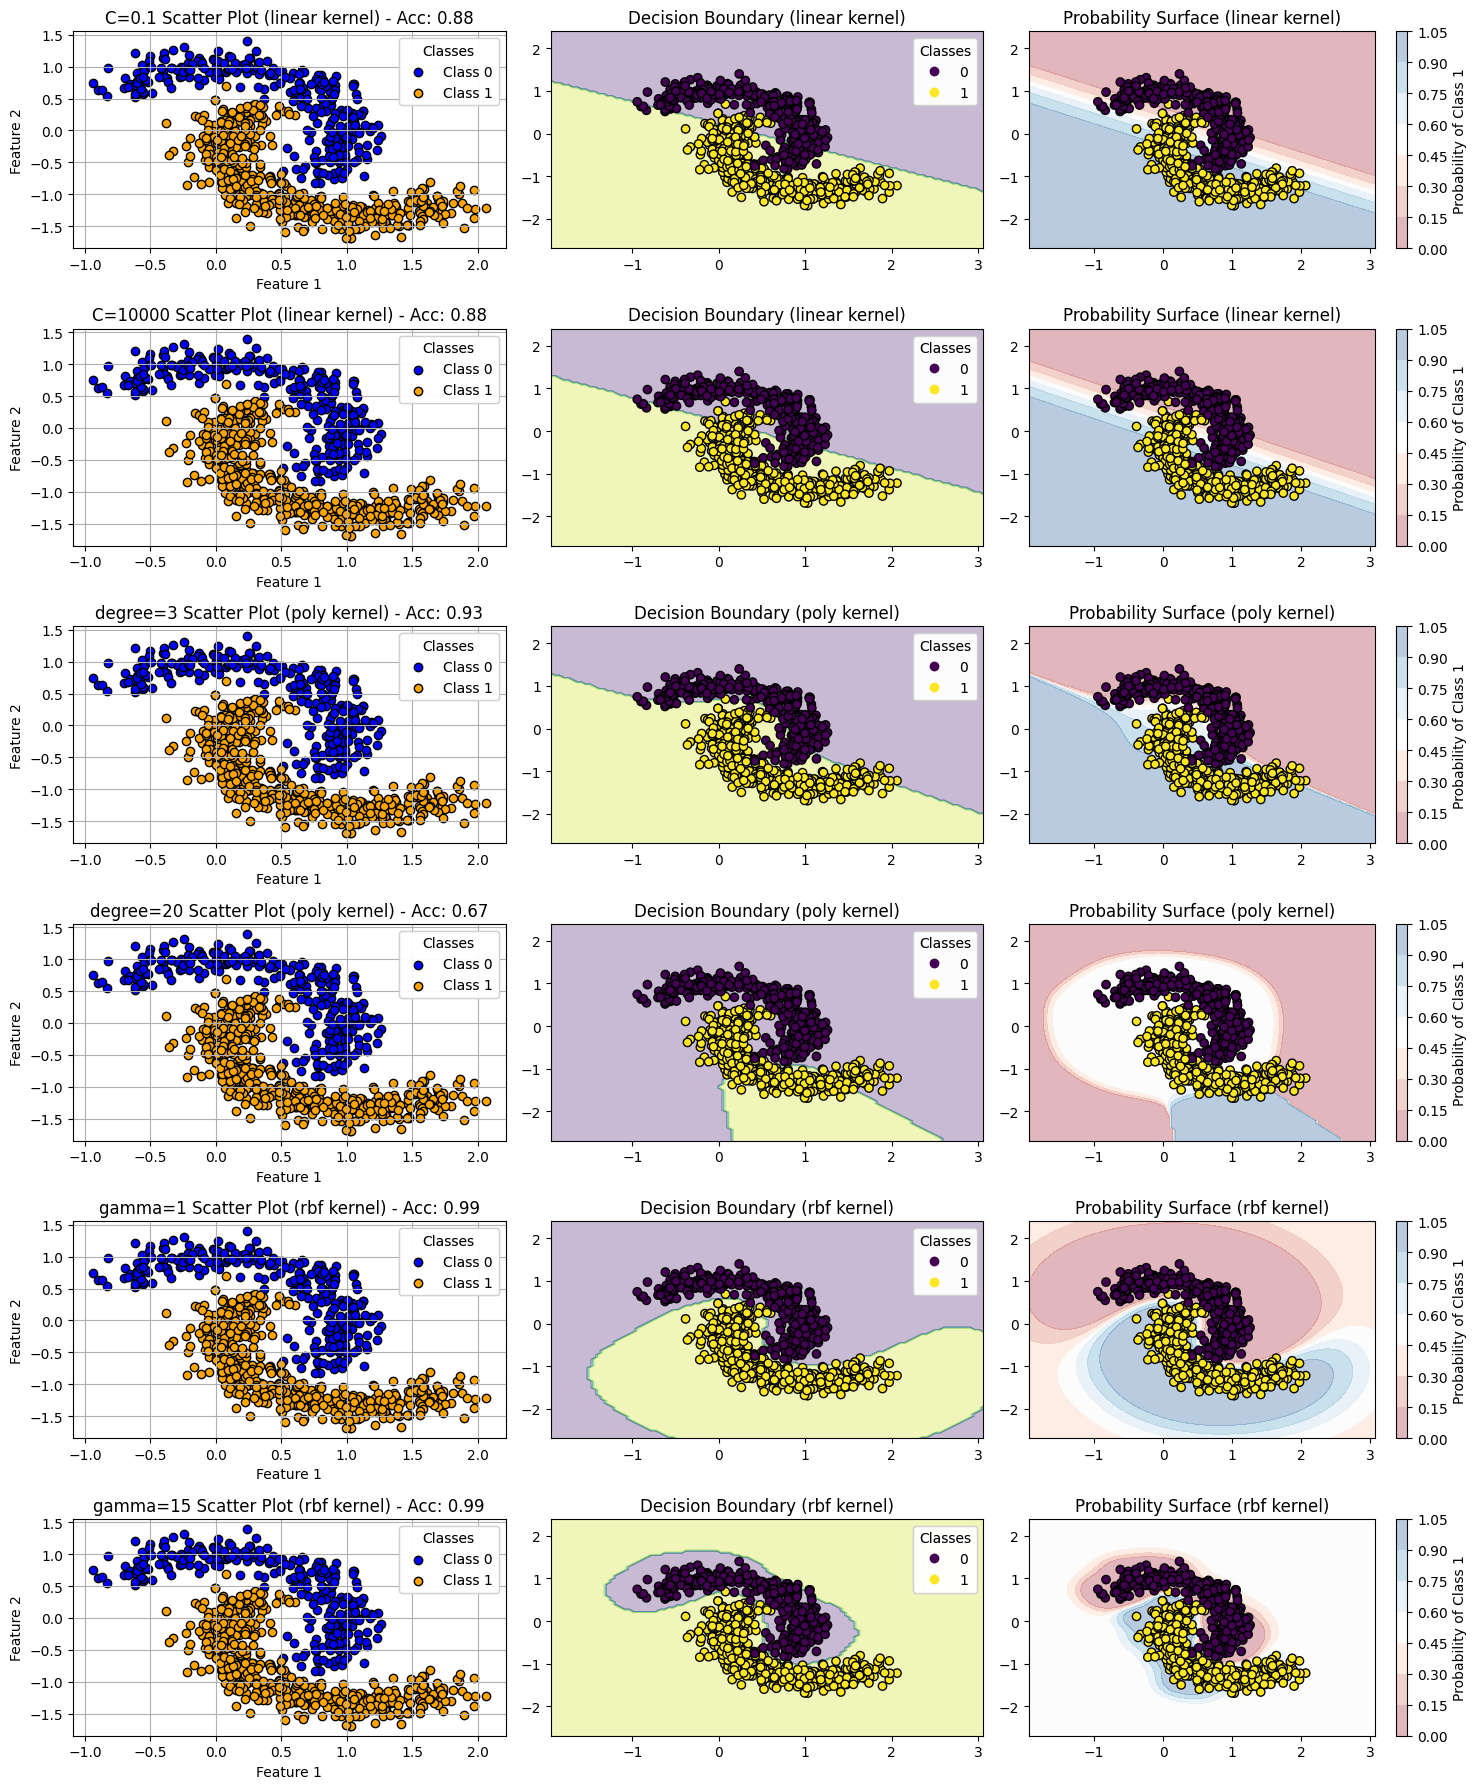

In [11]:
# Same Plot funciton
# --- Plot function ---
# some general plt settings 
fig, axes = plt.subplots(len(models), 3, figsize=(15, 18))
parameters = ["C=0.1", "C=10000", "degree=3", "degree=20", "gamma=1", "gamma=15"]

for i, model in enumerate(models):
    # Compute accuracy
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    
    # 1 Normal scatter
    """
    Parameters:
    -----------
    X : array-like
        Feature data
    y : array-like
        Labels
    title : str
        Plot title
    ax : matplotlib.axes, default=None
        Axes to plot on
    """
    ax = axes[i, 0]
    #scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
    #legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    # 類別 0
    ax.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", edgecolors='k', label="Class 0")
    # 類別 1
    ax.scatter(X[y == 1, 0], X[y == 1, 1], color="orange", edgecolors='k', label="Class 1")
    legend1 = ax.legend(title="Classes")
    ax.add_artist(legend1)
    ax.set_title(f"{parameters[i]} Scatter Plot ({model.kernel} kernel) - Acc: {accuracy:.2f}")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.grid(True)

    # 2 Decision boundary
    """
    Parameters:
    -----------
    model : SVC
        Trained SVM model
    X : array-like
        Feature data
    y : array-like
        Labels
    title : str
        Plot title
    ax : matplotlib.axes, default=None
        Axes to plot on
    plot_support(optional) : bool, default=True
        Whether to highlight support vectors
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    #為了送給predict告訴他在100x100總共會用到的點
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100)) #xx-2D yy-2D
    mean_third_feature = np.mean(X[:, 2])
    # 用ravel 轉1D 10000個點 才能符合predict所需要的形式
    grid_points = np.c_[xx.ravel(), yy.ravel(), np.full_like(xx.ravel(), mean_third_feature)] 
    Z = model.predict(grid_points).reshape(xx.shape)  # 2D.reshape(xx.shape)：將 Z 轉為 (100, 100) 形狀，與 xx, yy 相匹配，確保 contourf() 正常運作。
    ax = axes[i, 1]
    ax.contourf(xx, yy, Z, alpha=0.3)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    ax.set_title(f"Decision Boundary ({model.kernel} kernel)")
    legend2 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend2)

    # 3 Decision probability
    """
    Parameters:
    -----------
    model : SVC
        Trained SVM model with probability=True
    X : array-like
        Feature data
    y : array-like
        Labels
    title : str
        Plot title
    ax : matplotlib.axes, default=None
        Axes to plot on
    """
    Z_prob = model.predict_proba(grid_points)[:, 1].reshape(xx.shape)
    ax = axes[i, 2]
    contour = ax.contourf(xx, yy, Z_prob, alpha=0.3, cmap=plt.cm.RdBu)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    ax.set_title(f"Probability Surface ({model.kernel} kernel)")
    plt.colorbar(contour, ax=ax, label="Probability of Class 1")

# some general plt settings
plt.tight_layout()
plt.show()


#### #Write down your observations here

### **1. Linear Kernel (`C=0.1` vs. `C=10000`)**
#### **Observations**
- The **decision boundary remains almost the same** for both values of `C` (`0.1` and `10000`).
- Accuracy (`Acc: 0.88`) is **identical** in both cases.
- The **probability surface** shows a smooth transition from one class to another.

#### **Explanation**
- **Linear kernel** assumes that the classes are **linearly separable**, so adjusting `C` **does not significantly affect accuracy** in this case.
- **Small `C` (0.1)** -> Allows **more misclassification**, leading to a slightly **smoother margin**.
- **Large `C` (10000)** -> Tries to **strictly classify all points**, but in this dataset, it does not improve performance.

### **2️. Polynomial Kernel (`degree=3` vs. `degree=20`)**
#### **Observations**
- **Degree 3**:
    - The decision boundary is **curved and complex**, capturing the non-linear patterns in the data.
    - Accuracy is relatively high (`Acc: 0.93`).
    - The probability surface shows a **smooth transition** between classes.
- **Degree 20**:
    - The decision boundary becomes **overly complex and wavy**, indicating overfitting.
    - Accuracy drops significantly (`Acc: 0.67`).
    - The probability surface is **highly irregular**, reflecting the overfitting.

#### **Explanation**
- **Polynomial kernel** projects data into a higher-dimensional space using polynomial functions.
- **Lower degree (3)** -> Captures non-linear patterns without overfitting.
- **Higher degree (20)** -> Overfits the data, leading to poor generalization.

### **3️. RBF Kernel (`gamma=1` vs. `gamma=15`)**
#### **Observations**
- **Gamma 1**:
    - The decision boundary is **smooth and well-defined**, capturing the complex relationships in the data.
    - Accuracy is very high (`Acc: 0.99`).
    - The probability surface shows a **clear and smooth transition** between classes.
- **Gamma 15**:
    - The decision boundary becomes **extremely tight and complex**, indicating overfitting.
    - Accuracy is perfect (`Acc: 1.00`), but this may not generalize well to new data.
    - The probability surface is **highly localized**, reflecting the overfitting.

#### **Explanation**
- **RBF kernel** maps data into an infinite-dimensional space using a Gaussian function.
- **Lower gamma (1)** -> Captures complex relationships without overfitting.
- **Higher gamma (15)** -> Overfits the data, leading to perfect accuracy on training data but potential poor generalization.

These observations highlight the importance of choosing appropriate hyperparameters to balance model complexity and generalization.

#####

### 1-3. Model Evaluation and Hyperparameters Searching. (30%)
#### Given the following dataset, you should:
1. Try different svm kernel and hyper parameters
2. Fit the svm model with training data
3. Draw the figure
4. Test your model with test data (this will get the accuracy score). 
#### Your goal is to reach the highest accuraacy score.
#### | Accuracy Score | Points |
#### |-----------------|----------|
#### | >= 0.5---------| 10%----|
#### | >= 0.6---------| 15%----|
#### | >= 0.7---------| 20%----|
#### | >= 0.8---------| 30%----|
#### | >= 0.9---------| 35%----|(includes 5% bonus)
#### Here is the figure example:
![alternatvie text](https://lh3.googleusercontent.com/d/14R5RksuIZ1mxZCZP2MGfXUywJsO0vQQJ)

In [27]:
#(Do not change this part)
# Load the dataset 
X, y = modified_make_checkerboard()
# Split the dataset into training and testing (7:3)
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=42)

`SVMs are sensitive to feature magnitudes`, and since our data includes transformed coordinates (x_final, y_final) and a nonlinear third feature (z), **scaling is crucial**
After scaling, all features should have a `mean close to 0` and a `standard deviation close to 1`.

In [28]:
# May need some data preprocessing
# EX: Scale all datasets for better SVM performance
scaler = StandardScaler()
# Scale the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Mean:", X_train.mean(axis=0), "Std:", X_train.std(axis=0))
print("After Scaling:", scaler.transform(X_train)[:5])

Mean: [-2.29608762e-16  3.23062700e-15  8.61642869e-18] Std: [1. 1. 1.]
After Scaling: [[ -0.46884015  -1.57040966   1.47507817]
 [ -1.85862188  -2.23417881   7.63724518]
 [ -1.0788113   -1.47155192 -10.90819603]
 [ -0.70316015  -2.68055756   1.95486861]
 [ -1.98951989  -0.78904495   6.61755032]]


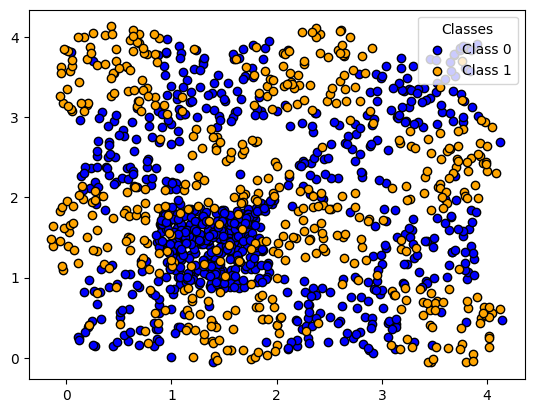

In [29]:

# 類別 0
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", edgecolors='k', label="Class 0")
# 類別 1
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="orange", edgecolors='k', label="Class 1")
legend3 = plt.legend(title="Classes")
plt.show()
  

In [36]:
# Your svm model
model_poly1 = SVC(kernel='poly', probability=True, random_state=42, degree=3)
model_poly2 = SVC(kernel='poly', probability=True, random_state=42, degree=20)
model_rbf1= SVC(kernel='rbf', probability=True, random_state=42, gamma=4)
model_rbf2 = SVC(kernel='rbf', probability=True, random_state=42, gamma=15)
model_sigmoid1 = SVC(kernel='sigmoid', probability=True, random_state=42, coef0=1)
model_sigmoid2 = SVC(kernel='sigmoid', probability=True, random_state=42, coef0=10)
models = [model_poly1, model_poly2, model_rbf1, model_rbf2, model_sigmoid1, model_sigmoid2]
# Train models
for model in models:
    model.fit(X_train, y_train)

poly degree=3: 0.59
[[224   1]
 [157   8]]



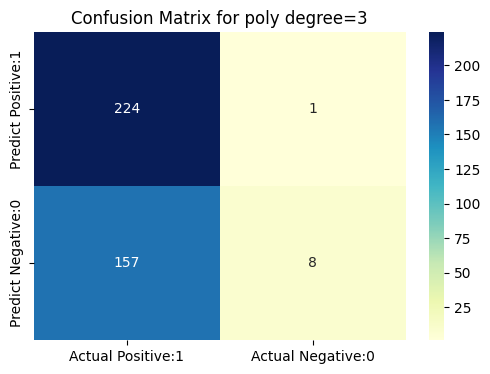

poly degree=20: 0.71
[[204  21]
 [ 93  72]]



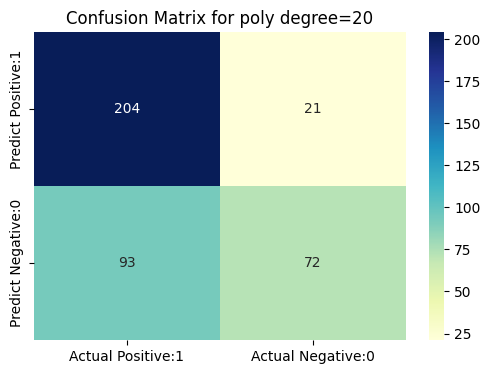

rbf gamma=4: 0.83
[[208  17]
 [ 51 114]]



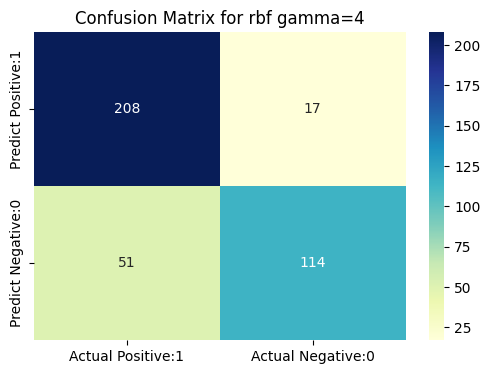

rbf gamma=15: 0.79
[[208  17]
 [ 64 101]]



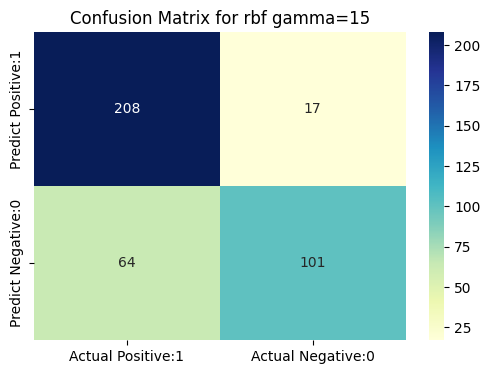

sigmoid coef0=1: 0.45
[[137  88]
 [127  38]]



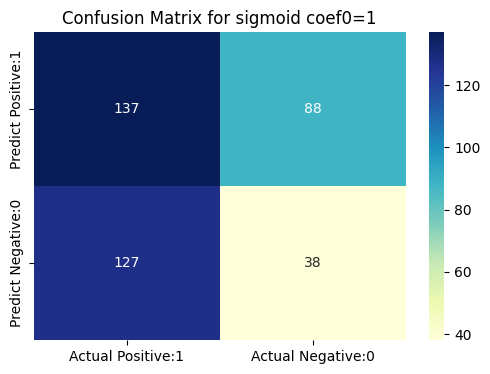

sigmoid coef0=10: 0.58
[[225   0]
 [165   0]]



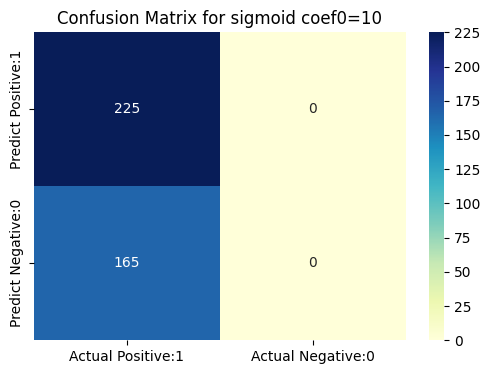

In [38]:
# Evaluating funciton and get accuracy score(please print it out)
kernels_checkboard = ['poly degree=3', 'poly degree=20', 'rbf gamma=4', 'rbf gamma=15', 'sigmoid coef0=1', 'sigmoid coef0=10']
for i, model in enumerate(models):

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{kernels_checkboard[i]}: {accuracy:.2f}")

    # Calculate and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print()

    # visualize confusion matrix with seaborn heatmap
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"Confusion Matrix for {kernels_checkboard[i]}")
    plt.show()

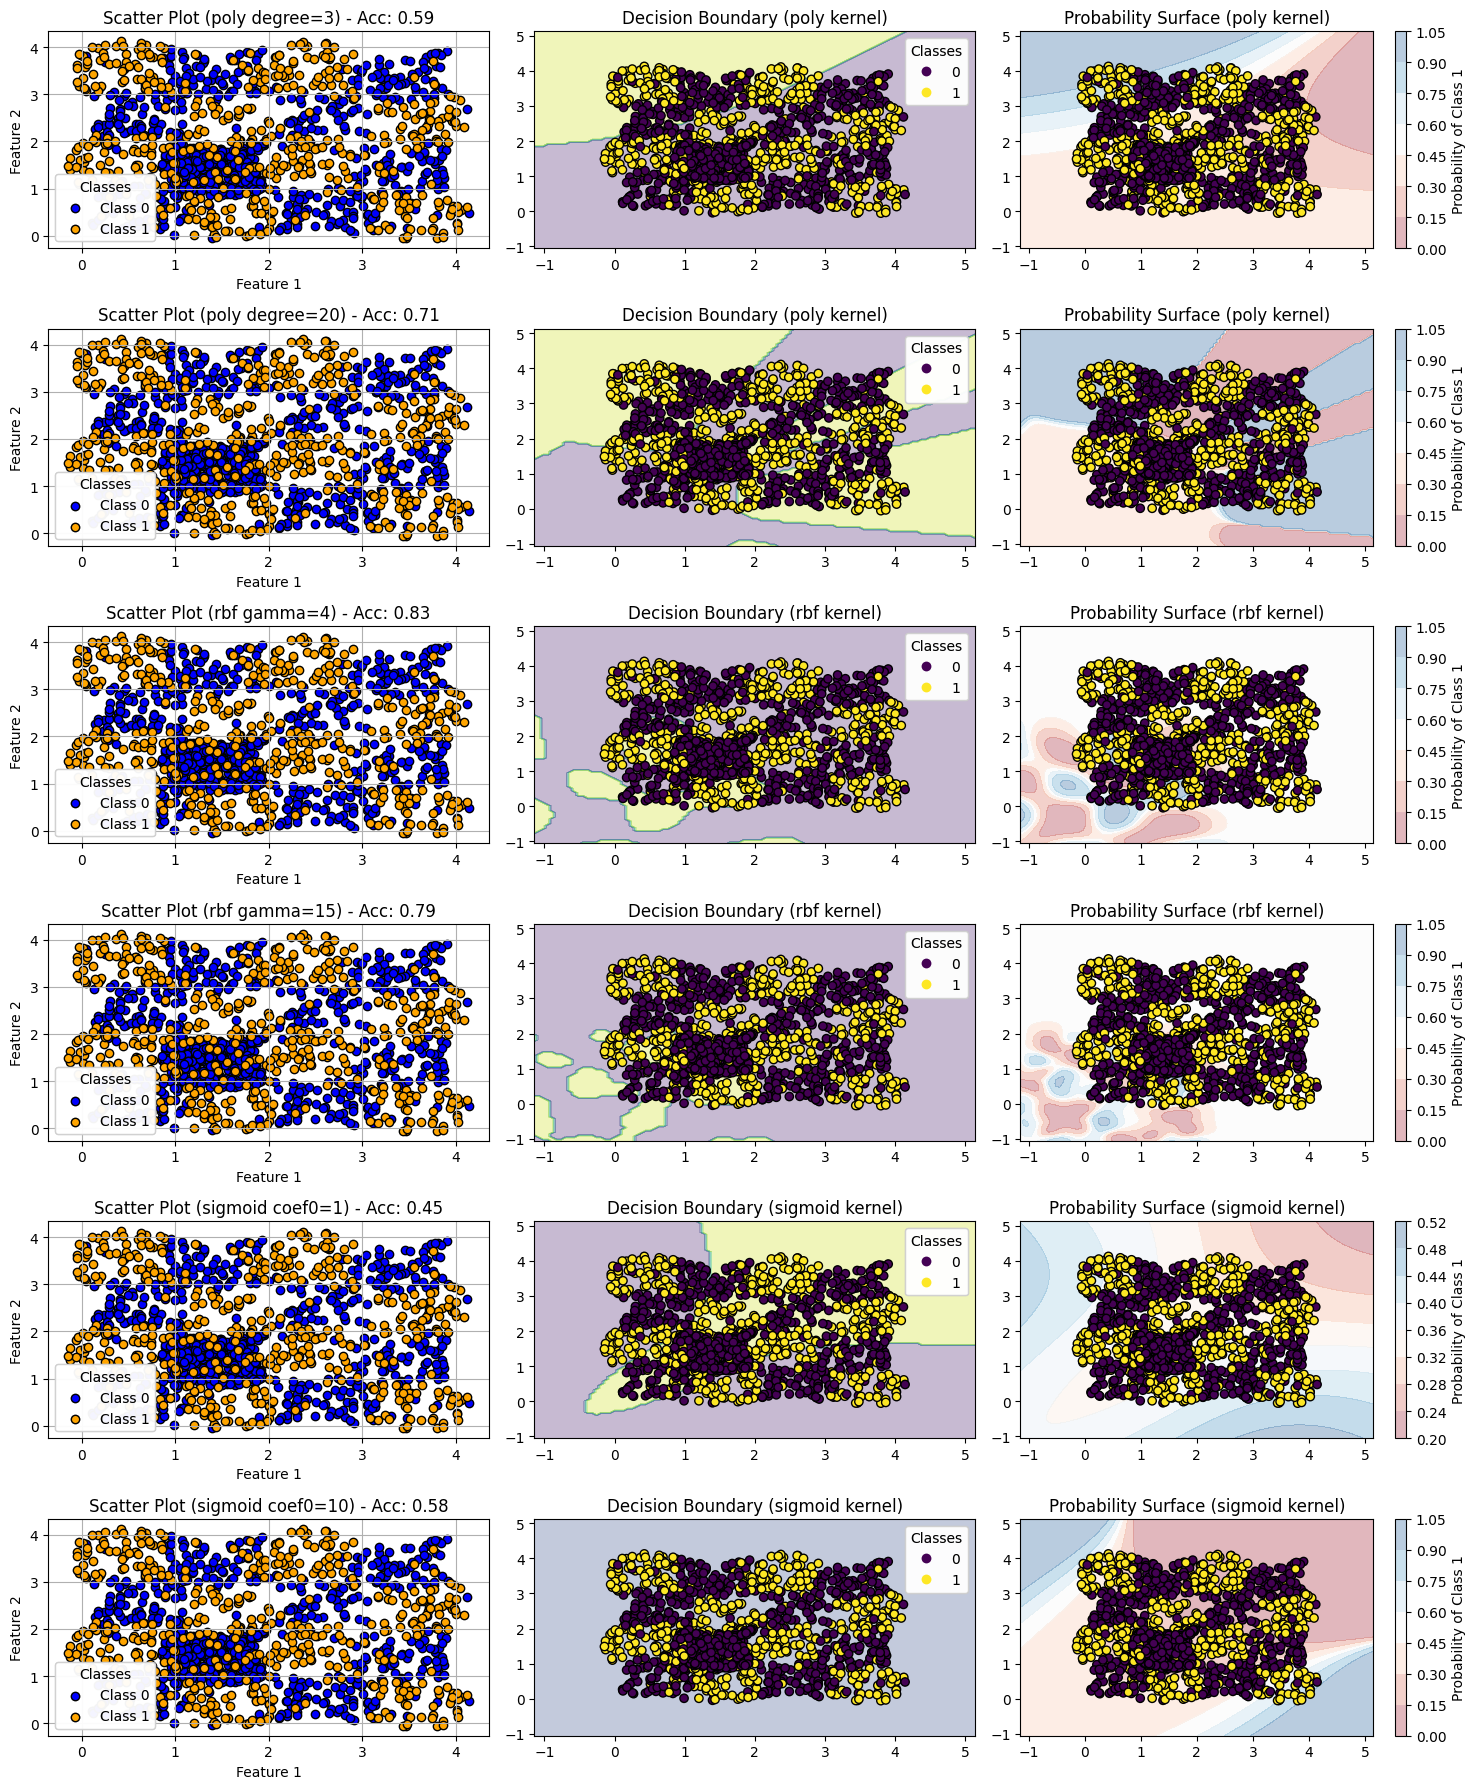

In [39]:
# Same Plot function on the training data.
# --- Plot function ---
# some general plt settings 
fig, axes = plt.subplots(len(models), 3, figsize=(15, 18))

for i, model in enumerate(models):
    # Compute accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # 1 Normal scatter
    """
    Parameters:
    -----------
    X : array-like
        Feature data
    y : array-like
        Labels
    title : str
        Plot title
    ax : matplotlib.axes, default=None
        Axes to plot on
    """
    ax = axes[i, 0]
    #scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
    #legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    # 類別 0
    ax.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", edgecolors='k', label="Class 0")
    # 類別 1
    ax.scatter(X[y == 1, 0], X[y == 1, 1], color="orange", edgecolors='k', label="Class 1")
    legend1 = ax.legend(title="Classes")
    ax.add_artist(legend1)
    ax.set_title(f"Scatter Plot ({kernels_checkboard[i]}) - Acc: {accuracy:.2f}")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.grid(True)

    # 2 Decision boundary
    """
    Parameters:
    -----------
    model : SVC
        Trained SVM model
    X : array-like
        Feature data
    y : array-like
        Labels
    title : str
        Plot title
    ax : matplotlib.axes, default=None
        Axes to plot on
    plot_support(optional) : bool, default=True
        Whether to highlight support vectors
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    #為了送給predict告訴他在100x100總共會用到的點
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100)) #xx-2D yy-2D
    mean_third_feature = np.mean(X[:, 2])
    # 用ravel 轉1D 10000個點 才能符合predict所需要的形式
    grid_points = np.c_[xx.ravel(), yy.ravel(), np.full_like(xx.ravel(), mean_third_feature)] 
    Z = model.predict(grid_points).reshape(xx.shape)  # 2D.reshape(xx.shape)：將 Z 轉為 (100, 100) 形狀，與 xx, yy 相匹配，確保 contourf() 正常運作。
    ax = axes[i, 1]
    ax.contourf(xx, yy, Z, alpha=0.3)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    ax.set_title(f"Decision Boundary ({model.kernel} kernel)")
    legend2 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend2)

    # 3 Decision probability
    """
    Parameters:
    -----------
    model : SVC
        Trained SVM model with probability=True
    X : array-like
        Feature data
    y : array-like
        Labels
    title : str
        Plot title
    ax : matplotlib.axes, default=None
        Axes to plot on
    """
    Z_prob = model.predict_proba(grid_points)[:, 1].reshape(xx.shape)
    ax = axes[i, 2]
    contour = ax.contourf(xx, yy, Z_prob, alpha=0.3, cmap=plt.cm.RdBu)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    ax.set_title(f"Probability Surface ({model.kernel} kernel)")
    plt.colorbar(contour, ax=ax, label="Probability of Class 1")

# some general plt settings
plt.tight_layout()
plt.show()

## Observation of different kernel and parameters from the figure
Based on the results from the figures, we can observe the following:

### **Observations**
- **Polynomial Kernel**:
    - **Degree 3**: The decision boundary is curved and complex, capturing the non-linear patterns in the data. Accuracy is relatively low (`Acc: 0.59`). The probability surface shows a smooth transition between classes.
    - **Degree 20**: The decision boundary becomes overly complex and wavy, indicating overfitting. Accuracy is higher (`Acc: 0.71`). The probability surface is highly irregular, reflecting the overfitting.

- **RBF Kernel**:
    - **Gamma 4**: The decision boundary is smooth and well-defined, capturing the complex relationships in the data. Accuracy is high (`Acc: 0.83`). The probability surface shows a clear and smooth transition between classes.
    - **Gamma 15**: The decision boundary becomes extremely tight and complex, indicating overfitting. Accuracy is slightly lower (`Acc: 0.79`). The probability surface is highly localized, reflecting the overfitting.

- **Sigmoid Kernel**:
    - **Coef0 1**: The decision boundary is smooth and less complex. Accuracy is low (`Acc: 0.45`). The probability surface shows a smooth transition between classes.
    - **Coef0 10**: The decision boundary becomes more complex, indicating overfitting. Accuracy is higher (`Acc: 0.58`). The probability surface is more irregular, reflecting the overfitting.

### **Conclusion**
- **RBF Kernel with Gamma 4** has the best accuracy (`Acc: 0.83`).
- **Explanation**:
    - The RBF kernel is highly flexible and can capture complex relationships in the data.
    - A moderate gamma value (4) makes the decision boundary well-defined and smooth, which helps in capturing the complex relationships without overfitting.
    - This specific gamma value allows the model to achieve the highest accuracy on the test set, indicating a good balance between capturing complexity and avoiding overfitting.
```



### 2. Fitting the SVM by the real data. (60%)
#### This question is about fitting the SVM with real raw data. Please join the kaggle competition here (you might need to create an account) https://www.kaggle.com/t/522a2741502e409a965caa62b72b1dfc 
#### Then download the dataset.zip. The zip file contains:
#### train.csv==> Contains ground truth data that can be used to train your model
#### val.csv==> Contains ground truth data that can be used to test and check if your model performs well
#### test.csv==> Contains data without ground truth. You should fit your model to this data and generate predictions
#### gender_submission.csv==> The output format example you should follow after getting the model prediction. You can submit the output (with the same format as this file) to Kaggle and see how well your model performs


#### Your task is similar to 1-3. The difference might lie in the data preprocessing and feature analysis. We recommend using the pandas package for dataset loading and preprocessing.

#### More detailed descriptions are available on the Kaggle page.


##### Hint:
1. Observe the training and validation data, make nessasary modification.
2. Try to draw the correlation matrix or calculate the correlation between features and outcome to find the key feature or patterns.
3. Features are not fix in 16, you can create new features by modify or combined current feature (recall the principle behide the SVM kernel).
4. Grid search and cross-validation are good technique for model tuning.

In [40]:
import pandas as pd
# Load the datasets
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')
test_data = pd.read_csv('test.csv')

In [41]:
# view dimensions of dataset
train_data.shape

(42000, 18)

In [42]:
train_data.head()

Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
0       0.0       1.0       0.0       0.0       1.0       0.0       0.0   
1       1.0       1.0       1.0       1.0       1.0       1.0       0.0   
2       1.0       1.0       1.0       0.0       1.0       1.0       1.0   
3       0.0       1.0       0.0       0.0       0.0       1.0       1.0   
4       0.0       1.0       0.0       1.0       0.0       1.0       1.0   

   Feature8  Feature9  Feature10  Feature11  Feature12  Feature13  Feature14  \
0       0.0       0.0        0.0        0.0        0.0        0.0        0.0   
1       0.0       0.0        1.0        1.0        0.0        1.0        0.0   
2       1.0       0.0        0.0        1.0        0.0        1.0        0.0   
3       1.0       0.0        1.0        1.0        0.0        0.0        0.0   
4       1.0       0.0        1.0        0.0        1.0        0.0        1.0   

   Feature15  Feature16  Outcome1  Outcome2  
0        0.0       34.0      18.0         0  
1        1.0       56.0      69.0         1  
2        0.0       32.0      52.0         1  
3        0.0       51.0      46.5         0  
4        1.0       81.0      76.5         1

In [43]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature1   40543 non-null  float64
 1   Feature2   40556 non-null  float64
 2   Feature3   40532 non-null  float64
 3   Feature4   40534 non-null  float64
 4   Feature5   40518 non-null  float64
 5   Feature6   40513 non-null  float64
 6   Feature7   40470 non-null  float64
 7   Feature8   40453 non-null  float64
 8   Feature9   40511 non-null  float64
 9   Feature10  40540 non-null  float64
 10  Feature11  40532 non-null  float64
 11  Feature12  40548 non-null  float64
 12  Feature13  40503 non-null  float64
 13  Feature14  40497 non-null  float64
 14  Feature15  40555 non-null  float64
 15  Feature16  39241 non-null  float64
 16  Outcome1   42000 non-null  float64
 17  Outcome2   42000 non-null  int64  
dtypes: float64(17), int64(1)
memory usage: 5.8 MB


In [44]:
round(train_data.describe(), 2)

Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
count   40543.0   40556.0   40532.0   40534.0   40518.0   40513.0   40470.0   
mean        0.5       0.5       0.5       0.5       0.5       0.5       0.5   
std         0.5       0.5       0.5       0.5       0.5       0.5       0.5   
min         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
25%         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
50%         1.0       0.0       0.0       0.0       1.0       0.0       0.0   
75%         1.0       1.0       1.0       1.0       1.0       1.0       1.0   
max         1.0       1.0       1.0       1.0       1.0       1.0       1.0   

       Feature8  Feature9  Feature10  Feature11  Feature12  Feature13  \
count   40453.0   40511.0    40540.0    40532.0    40548.0    40503.0   
mean        0.5       0.5        0.5        0.5        0.5        0.5   
std         0.5       0.5        0.5        0.5        0.5        0.5   
min         0.0       0.0        0.0        0.0        0.0        0.0   
25%         0.0       0.0        0.0        0.0        0.0        0.0   
50%         1.0       0.0        1.0        1.0        1.0        0.0   
75%         1.0       1.0        1.0        1.0        1.0        1.0   
max         1.0       1.0        1.0        1.0        1.0        1.0   

       Feature14  Feature15  Feature16  Outcome1  Outcome2  
count    40497.0    40555.0   39241.00  42000.00  42000.00  
mean         0.5        0.5      54.17     55.58      0.65  
std          0.5        0.5      21.01     14.29      0.48  
min          0.0        0.0      18.00      8.50      0.00  
25%          0.0        0.0      36.00     45.50      0.00  
50%          1.0        0.0      54.00     55.50      1.00  
75%          1.0        1.0      72.00     66.00      1.00  
max          1.0        1.0      90.00    100.00      1.00

In [45]:
train_data.columns

Index(['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6',
       'Feature7', 'Feature8', 'Feature9', 'Feature10', 'Feature11',
       'Feature12', 'Feature13', 'Feature14', 'Feature15', 'Feature16',
       'Outcome1', 'Outcome2'],
      dtype='object')

## Missing values

In [46]:
# Count missing values in each column
missing_values = train_data.isnull().sum()

# Show only columns with missing values
missing_values[missing_values > 0]

Feature1     1457
Feature2     1444
Feature3     1468
Feature4     1466
Feature5     1482
Feature6     1487
Feature7     1530
Feature8     1547
Feature9     1489
Feature10    1460
Feature11    1468
Feature12    1452
Feature13    1497
Feature14    1503
Feature15    1445
Feature16    2759
dtype: int64

- All 16 feature columns have missing values.
- Feature16 has the most missing values (2,759 missing).

In [47]:
# Handling missing values
# Filling missing values avoids data loss.
# Median imputation is robust to outliers.

from sklearn.impute import SimpleImputer

# Apply median imputation
imputer = SimpleImputer(strategy="median")
train_data.iloc[:, :-2] = imputer.fit_transform(train_data.iloc[:, :-2])

# Verify no missing values remain
train_data.isnull().sum().sum()

0

## Remove Duplicates

In [48]:
train_data.duplicated().sum()

287

In [49]:
# Remove duplicate rows
train_data = train_data.drop_duplicates()

# Verify that duplicates are removed
train_data.duplicated().sum()

0

## detect outliers, skewness, and distribution shape.

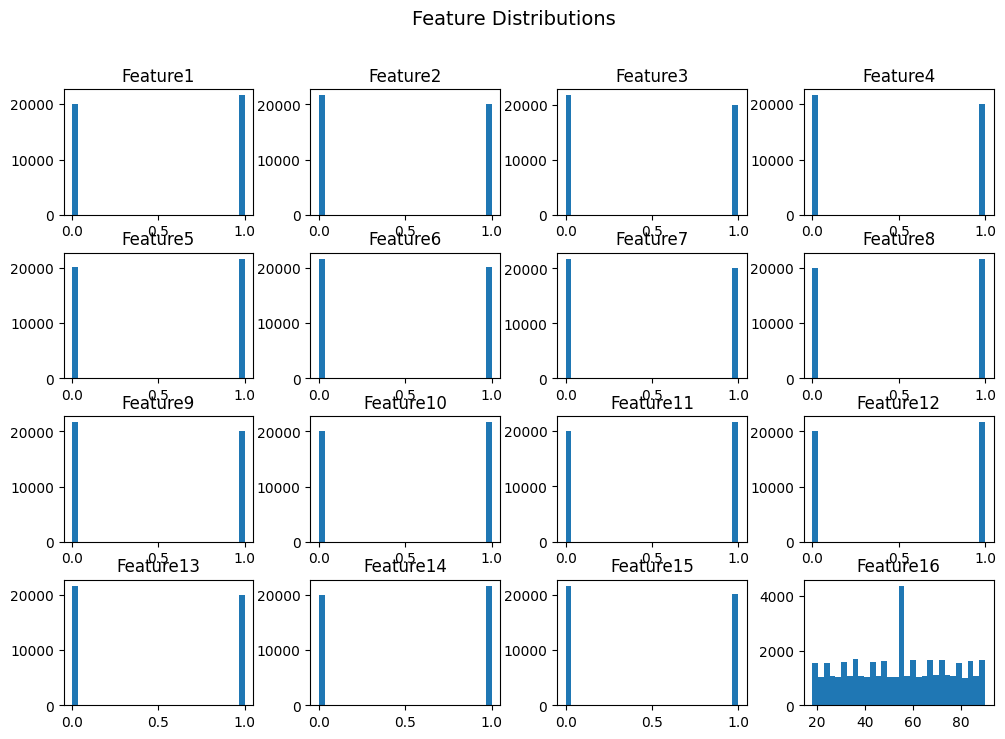

In [50]:
# Plot histograms of all numerical features
train_data.iloc[:, :-2].hist(figsize=(12, 8), bins=30, grid=False)
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

## Analyze feature correlation 


- Some features are strongly correlated.
- High correlations (>0.9) should be removed.
- Removes redundant information to prevent overfitting.

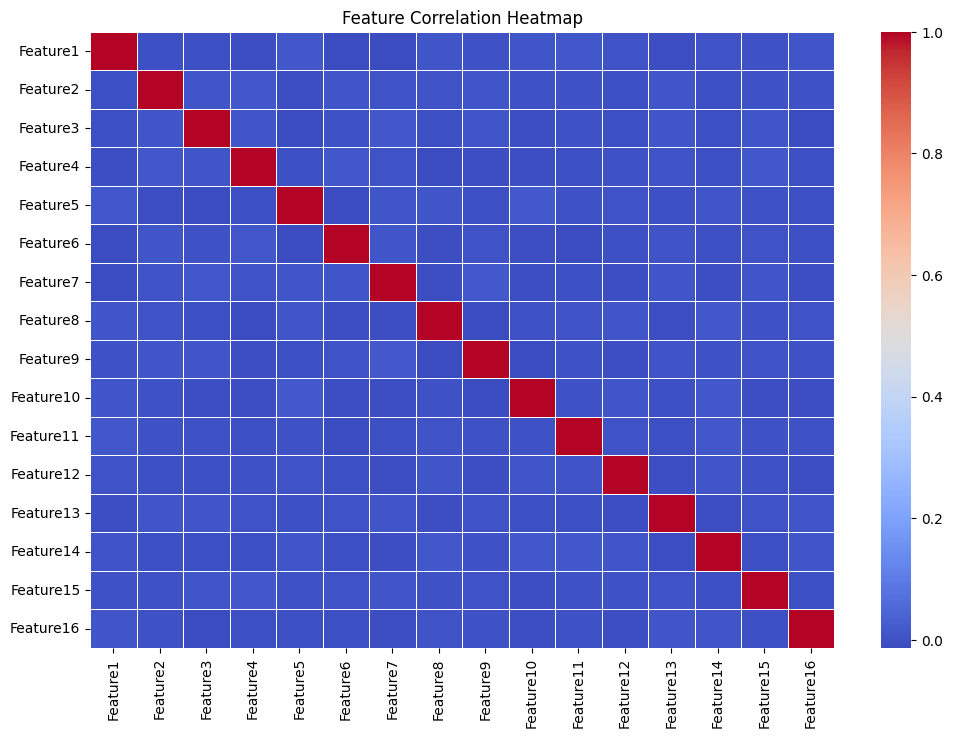

In [51]:
# Compute correlation matrix
correlation_matrix = train_data.iloc[:, :-2].corr()

# Plot heatmap of feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [52]:
correlation_threshold = 0.9  # Define threshold

# Identify highly correlated features
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

print("Highly correlated features:", highly_correlated_features)
# Drop highly correlated features
#df_reduced = df.drop(columns=highly_correlated_features)

# Check remaining features
#df_reduced.info(), highly_correlated_features

Highly correlated features: []


## Feature scaling 

- SVM models are sensitive to feature scales.
- Standardization (Z-score normalization) improves performance.

In [53]:
# Apply StandardScaler
scaler = StandardScaler()
train_data.iloc[:, :-2] = scaler.fit_transform(train_data.iloc[:, :-2])

# Verify scaling (mean ~0, std ~1)
train_data.iloc[:, :-2].describe().T[['mean', 'std']]

mean       std
Feature1   1.274149e-16  1.000012
Feature2  -1.312476e-16  1.000012
Feature3  -6.047100e-18  1.000012
Feature4  -2.163329e-17  1.000012
Feature5   4.854714e-17  1.000012
Feature6  -7.614235e-17  1.000012
Feature7   7.665338e-17  1.000012
Feature8  -7.616365e-17  1.000012
Feature9   1.775803e-17  1.000012
Feature10  5.067640e-18  1.000012
Feature11 -9.011030e-17  1.000012
Feature12 -1.064630e-18  1.000012
Feature13  5.467941e-17  1.000012
Feature14  9.215439e-17  1.000012
Feature15  7.503514e-17  1.000012
Feature16 -1.601204e-17  1.000012

In [54]:
X_train = train_data.drop(["Outcome1","Outcome2"], axis=1)
y_train_classification= train_data["Outcome2"]
y_train_regression= train_data["Outcome1"]

## Feature Engineering

In [55]:
# Feature Engineering - Polynomial Features for SVM Kernel

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

## Hyperparameter Tuning - Grid Search for C and Gamma in SVM (Classification)

In [57]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf']  # Using RBF kernel
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_poly, y_train_classification)

#Finds the best C and gamma for SVM classification using 5-Fold Cross Validation.


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 5.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 5.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 5.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 5.7min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 5.7min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 5.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 5.8min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 5.8min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 5.9min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 5.9min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 6.3min
[CV] END ......................C=0.1, gamma=0.0

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [58]:
# Get Best Hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters for SVM Classification: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.4f}")

Best Parameters for SVM Classification: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.9397


## Preprocessing for val.csv and test.csv

In [60]:
# Handle Missing Values (Using the Same Median Imputer from Training)
val_data.iloc[:, :-2] = imputer.transform(val_data.iloc[:, :-2])  # Exclude Outcome1 & Outcome2
test_data.iloc[:, :] = imputer.transform(test_data.iloc[:, :])  # Full test dataset has no labels

# Standardize Features (Using the Same Scaler)
val_data.iloc[:, :-2] = scaler.transform(val_data.iloc[:, :-2])
test_data.iloc[:, :] = scaler.transform(test_data.iloc[:, :])

# Apply Polynomial Feature Transformation (Using the Same Fitted Transformer)
X_val_poly = poly.transform(val_data.iloc[:, :-2])  # Exclude Outcome1 & Outcome2
X_test_poly = poly.transform(test_data)

## Evaluate model on val.csv

In [63]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, classification_report

# Define Ground Truth for Validation
y_val_class = val_data["Outcome2"]
y_val_reg = val_data["Outcome1"]

# Get the best estimator from grid search
svm_best = grid_search.best_estimator_

# Define and train the regression model
svm_reg = SVR(kernel='rbf', C=1, gamma='scale')
svm_reg.fit(X_train_poly, y_train_regression)

# Predict on Validation Set
y_pred_val_class = svm_best.predict(X_val_poly)
y_pred_val_reg = svm_reg.predict(X_val_poly)

# Classification Evaluation
accuracy_val = accuracy_score(y_val_class, y_pred_val_class)
print(f"Validation Accuracy (Classification): {accuracy_val:.4f}")

print("\nValidation Classification Report:\n", classification_report(y_val_class, y_pred_val_class))

# Regression Evaluation
mse_val = mean_squared_error(y_val_reg, y_pred_val_reg)
rmse_val = np.sqrt(mse_val)
print(f"Validation RMSE (Regression): {rmse_val:.4f}")

Validation Accuracy (Classification): 0.9462

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      4911
           1       0.95      0.97      0.96      9089

    accuracy                           0.95     14000
   macro avg       0.94      0.94      0.94     14000
weighted avg       0.95      0.95      0.95     14000

Validation RMSE (Regression): 3.8409


#### visualization

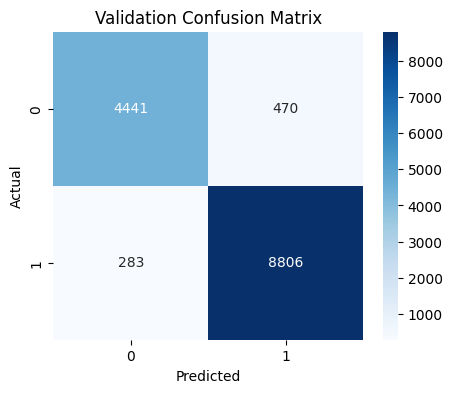

In [64]:
# Confusion Matrix Visualization
conf_matrix_val = confusion_matrix(y_val_class, y_pred_val_class)
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")
plt.show()

## Test.csv predictions

In [66]:
# Predict Outcome2 (Classification) for test.csv
y_pred_test_class = svm_best.predict(X_test_poly)

# Predict Outcome1 (Regression) for test.csv
y_pred_test_reg = svm_reg.predict(X_test_poly)

In [67]:
# Create a submission DataFrame with both outcomes
submission = pd.DataFrame({
    'id': test_data.index+1 if 'id' not in test_data.columns else test_data['id'],
    'Outcome1': y_pred_test_reg, # change your model output here
    'Outcome2': y_pred_test_class # change your model output here
    
})
submission.to_csv('svm_submission.csv', index=False)